### Overview

### Loss

## **Model**

In [61]:
import numpy as np

In [62]:
import copy
import math

def node_score_error(prob):
    '''
        TODO:
        Calculate the node score using the train error of the subdataset and return it.
        For a dataset with two classes, C(p) = min{p, 1-p}
    '''
    return min(prob, 1-prob)

def node_score_entropy(prob):
    '''
        TODO:
        Calculate the node score using the entropy of the subdataset and return it.
        For a dataset with 2 classes, C(p) = -p * log(p) - (1-p) * log(1-p)
        For the purposes of this calculation, assume 0*log0 = 0.
        HINT: remember to consider the range of values that p can take!
    '''
    # HINT: If p < 0 or p > 1 then entropy = 0
    if prob < 0 or prob > 1: entropy = 0
    elif prob == 0 or prob == 1:
        entropy = -1 * np.log(1)
    else:
        entropy = -prob * np.log(prob) - (1-prob) * np.log(1-prob)
    
    return entropy

def node_score_gini(prob):
    '''
        TODO:
        Calculate the node score using the gini index of the subdataset and return it.
        For dataset with 2 classes, C(p) = 2 * p * (1-p)
    '''
    return 2 * prob * (1-prob)

In [259]:
class Stump(object):
    def __init__(self, distribution, gain_function=node_score_gini):
        # TODO
        self.gain_function = gain_function
        self.distribution = distribution # D^(t) for this learner
        self.split_ftr_indx = None
        self.split_point = None
    def train(self,X,y):
        # TODO: training function for a stump ?
        ftrs = X.shape[1]
        # loop over all ftrs
        gains = []
        split_points = []
        for f in range(ftrs):
            x_ftr = X[:,f]

            # over all possible values
            uniq = np.sort(np.unique(x_ftr))
            
            # check there are at least two values,
            # consistent ftrs skipped
            if uniq.shape[0] < 2:
                gains.append(-np.inf)
                split_points.append(None)
                continue
            
            mids = (uniq[1:] + uniq[:-1])/2 # midpoints
            local_gains = []

            for split in mids:
                x_true = x_ftr > split # get a boolean x based on split
                local_gains.append( self._calc_gain(x_true, y) )

            best_local_indx = int(np.argmax(local_gains))
            gains.append(local_gains[best_local_indx])
            split_points.append(mids[best_local_indx])

        best_gain_indx = int(np.argmax(gains))
        self.split_ftr_indx = best_gain_indx
        self.split_point = split_points[best_gain_indx]

        return None
    
    def loss(self, X, y):
        # TODO: redifined as 0-1 loss weighted by D^(t)
        #       in practice D^(t) is just a vector of weights length m
        y_hat = self.predict(X)
        return np.sum( self.distribution * (y_hat != y).astype(int) )
    
    def predict(self,X):
        # TODO: takes in a matrix X and outputs a vector of predictions y
        xi = X[:,self.split_ftr_indx]
        return np.where(xi < self.split_point, 1, -1)
    
    def _calc_gain(self, x_true, y):
        # TODO: calculate gain using weights from self.distribution
        w = self.distribution
        # p(y=1)
        cpy1 = self.gain_function((w*(y==1)).sum() / w.sum())
        if w[x_true].sum() > 0:
            py1_true = (w[x_true]*(y[x_true]==1)).sum() / w[x_true].sum()
        else:
            py1_true = 0.0
        if w[~x_true].sum() > 0:
            py1_false = (w[~x_true]*(y[~x_true]==1)).sum() / w[~x_true].sum()
        else:
            py1_false = 0.0

        c_true = self.gain_function(py1_true) * w[x_true].sum()
        c_false = self.gain_function(py1_false) * w[~x_true].sum()

        gain = cpy1 - ((c_true + c_false) / w.sum())
        return gain

In [260]:
class AdaBoost(object):

    def __init__(self, n_estimators=50, learner_class=Stump):

        self.n_estimators = n_estimators # number of learners T
        # self.lr = learning_rate # implement later?

        self.weights = None # weights for each learner
        self.learners = [] # list of Stump objects
        self.learner_class = learner_class

        self.distribution = None

    def train(self, X, y):
        
        # TODO: AdaBoost optimizer...
        m = X.shape[0]
        X = X.copy()
        y = y.copy()
        # make sure in range (-1,1)
        if set([0,1]).difference(np.unique(y)) == set():
            y = np.where(y == 0, -1, 1)
        # init D^(t) and w
        self.distribution = np.ones(m) * (1/m)
        self.weights = np.zeros(self.n_estimators)

        # for 1 to T
        for t in range(self.n_estimators):
            # invoke wl
            wl = self.learner_class(self.distribution)
            wl.train(X,y)

            # calculate weighted error and then w_t
            error = wl.loss(X,y)
            w_t = 0.5 * np.log( (1-error) / error )
            self.weights[t] = w_t

            self._update_distribution(w_t, X, y, wl)
            self.learners.append(wl)

        return None
    
    def predict(self, X):

        # takes in a matrix X with m rows
        y_hat = np.zeros(X.shape[0]) # initializes all predictions as 0
        # for each learner
        for t in range(self.n_estimators):
            y_hat_t = self.learners[t].predict(X) # predict for all rows
            y_hat += (self.weights[t] * y_hat_t) # update by weight

        return np.sign(y_hat)
    
    def loss(self, X, y):

        y_hat = self.predict(X)

        return np.mean(y_hat != y)
    
    def _update_distribution(self, w, X, y, wl):

        # TODO: function which calculates new D_t and updates it
        update = self.distribution * np.exp( -w * y * wl.predict(X) )
        D = update / np.sum(update)
        self.distribution = D

        return None

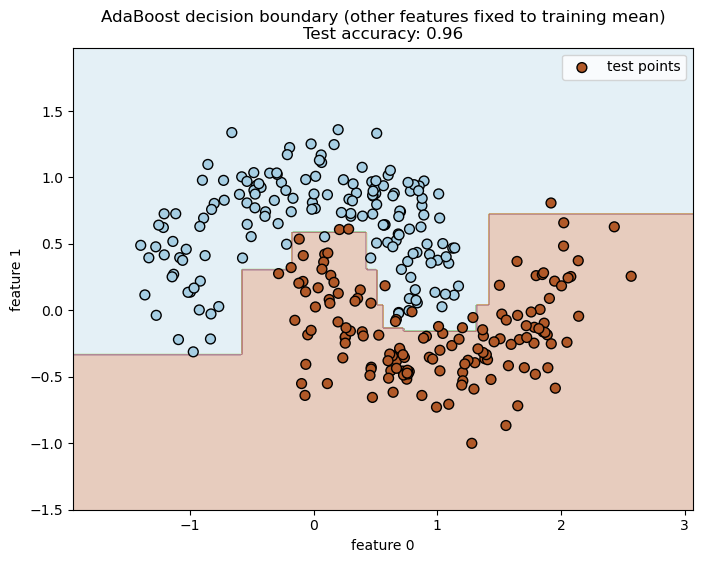

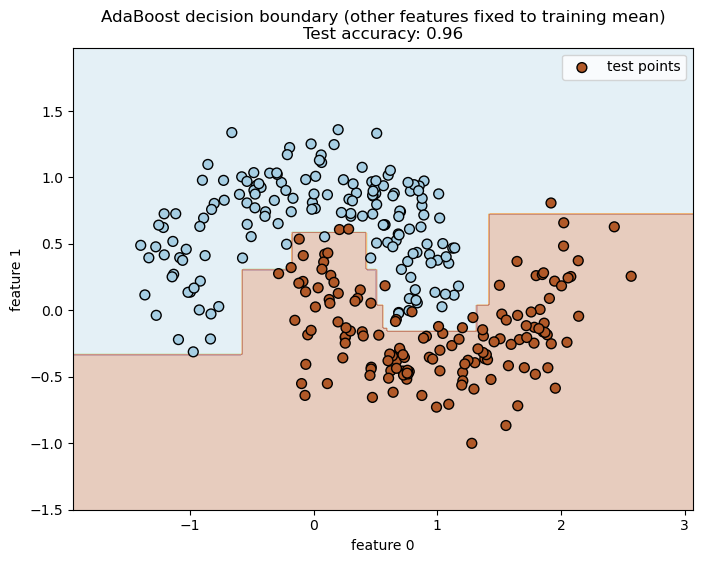

In [270]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

def plot_2d_clf(X, y, clf, random_state):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=random_state)
    # fit classifier
    try:
        clf.train(X_train, y_train)
    except AttributeError:
        clf.fit(X_train, y_train)

    # choose two features to visualize (0 and 1)
    x_idx, y_idx = 0, 1

    # mesh for plotting (cover both train and test ranges)
    xmin = np.min(np.r_[X_train[:, x_idx], X_test[:, x_idx]]) - 0.5
    xmax = np.max(np.r_[X_train[:, x_idx], X_test[:, x_idx]]) + 0.5
    ymin = np.min(np.r_[X_train[:, y_idx], X_test[:, y_idx]]) - 0.5
    ymax = np.max(np.r_[X_train[:, y_idx], X_test[:, y_idx]]) + 0.5
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 300), np.linspace(ymin, ymax, 300))

    # build full-dimensional grid points by fixing other features at their training mean
    mean_features = np.mean(X_train, axis=0)
    grid2d = np.c_[xx.ravel(), yy.ravel()]
    n_pts = grid2d.shape[0]
    full_grid = np.tile(mean_features, (n_pts, 1))
    full_grid[:, x_idx] = grid2d[:, 0]
    full_grid[:, y_idx] = grid2d[:, 1]

    # predict on the grid and plot
    Z = clf.predict(full_grid).reshape(xx.shape)

    try:
        test_score = clf.score(X_test, y_test)
    except:
        y_hat = clf.predict(X_test)
        y_hat = np.where(y_hat < 0, 0, 1)
        test_score = accuracy_score(y_test, y_hat)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
    plt.scatter(X_test[:, x_idx], X_test[:, y_idx], c=y_test, cmap=plt.cm.Paired, edgecolor='k', s=50, label='test points')
    plt.xlabel(f'feature {x_idx}')
    plt.ylabel(f'feature {y_idx}')
    plt.title(f'AdaBoost decision boundary (other features fixed to training mean)\nTest accuracy: {test_score:.2f}')
    plt.legend()
    plt.show()

    return None

RS = 42
X,y = make_moons(noise=0.2, random_state=RS, n_samples=1000)
plot_2d_clf(X, y, clf=AdaBoost(), random_state=RS)
plot_2d_clf(X, y, clf=AdaBoostClassifier(), random_state=RS)

## **Check Model**

In [268]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import zero_one_loss

# Methods for sklearn implementation testing
# Decision Stump: 
def gini_from_sklearn(x, y, d, stump=DecisionTreeClassifier(max_depth=1)):
    ''' Calculates the gini gain from a trained sklearn decision stump

    @params:
        x: a 2D (n_examples x n_features) numpy array  of training data
        y: a 1D (n_examples) numpy array with labels -1 or 1
        d: a 1D (n_examples) numpy array of sample weights
        stump: a sklearn DecisionTreeClassifier object initialized with max_depth=1
    @return:
        The difference in weighted gini impurity after the chosen split
    
    '''
    # fit the sklearn stump
    stump.fit(x, y, sample_weight=d)
    # get gini from root
    gini_root = stump.tree_.impurity[0]
    # get gini and weights after split
    gini_1,gini_2 = stump.tree_.impurity[1], stump.tree_.impurity[2]
    w = stump.tree_.weighted_n_node_samples
    p1, p2 = w[1]/w[0], w[2]/w[0]
    # calculate weighted gini difference
    return gini_root - ( (p1 * gini_1) + (p2 * gini_2) )

def split_from_sklearn(x,y,d,stump=DecisionTreeClassifier(max_depth=1)):
    ''' Trains a sklearn decision stump and returns the feature split on
        and the splitting threshold
    @params:
        x: a 2D (n_examples x n_features) numpy array  of training data
        y: a 1D (n_examples) numpy array with labels -1 or 1
        d: a 1D (n_examples) numpy array of sample weights
        stump: a sklearn DecisionTreeClassifier object initialized with max_depth=1
    @return:
        The index of the feature split on
        The threshold value used for splitting on that feature
    '''
    # fit the sklearn stump
    stump.fit(x, y, sample_weight=d)
    ftr = stump.tree_.feature[0]
    thresh = stump.tree_.threshold[0]
    return ftr, thresh

print(gini_from_sklearn(x1, y1, d1))

stump = Stump(distribution=d1)
stump.train(x1,y1)
print(stump.split_ftr_indx)
print(stump.split_point)
sk = DecisionTreeClassifier(max_depth=1)
sk.fit(x1,y1,sample_weight=d1)
print(stump.split_ftr_indx == split_from_sklearn(x1,y1,d1)[0])
print(stump.split_point == split_from_sklearn(x1,y1,d1)[1])

print(sk.predict(x1))
print(stump.predict(x1))
print(zero_one_loss(y1, sk.predict(x1),sample_weight=d1))
print(stump.loss(x1, y1))

0.12000000000000002
0
0.5
True
True
[ 1  1 -1 -1  1]
[ 1  1 -1 -1  1]
0.19999999999999996
0.2


In [247]:
import pytest
# initialize a random state
np.random.seed(0)

# test data
# x1 = np.random.choice([0,1], 30)[:15].reshape(5,3)
# print(x1.tolist())
x1 = np.array([[0, 1, 1], [0, 1, 1], [1, 1, 1], [1, 1, 0], [0, 1, 0]])

# y1 = np.sign(x1[:,0]*-1 + x1[:,1]*1 + x1[:,2]*-1 +0.01).astype(int)
# print(y1.tolist())
y1 = np.array([1, 1, -1, 1, 1])

# x2 = np.random.choice([0,1], 30)[15:].reshape(5,3)
# print(x2.tolist())
x2 = np.array([[1, 1, 1], [0, 1, 0], [1, 1, 1], [1, 0, 1], [0, 0, 1]])

# y2 = np.sign(x1[:,0]*-2 + x1[:,1]*1 + x1[:,2]*1 -0.01).astype(int)
# print(y2.tolist())
y2 = np.array([1, 1, -1, -1, 1])

## test `Stump` class ##
# learning from first point
d1 = np.ones(5)*(1/5)
stump = Stump(distribution=d1)
stump.train(x1, y1)
print(stump.split_ftr_indx)

0
